In [ ]:
# SPIKE AMPLITUDE PLOT

In [1]:
import os

if os.path.basename(os.getcwd()) == "illustration":
    os.chdir("..")

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [2]:
import datajoint as dj

In [5]:
from notebooks.illustration import plot_functions as plot

[2024-06-25 00:00:37,939][INFO]: Connecting milagros@db.datajoint.com:3306
[2024-06-25 00:00:39,297][INFO]: Connected milagros@db.datajoint.com:3306


In [26]:
# Import Modulues
import datetime
import spikeinterface as si
from spikeinterface import widgets, exporters, postprocessing, qualitymetrics, sorters
from workflow.pipeline import ephys
from workflow.utils.paths import (
    get_ephys_root_data_dir,
    get_raw_root_data_dir,
    get_processed_root_data_dir,
)
from element_interface.utils import dict_to_uuid, find_full_path, find_root_directory
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.image as image
from matplotlib import pyplot as plt
from workflow.utils.ingestion_utils import El2ROW

In [7]:
# Create Experiment Ditionaries
# experiment info , session times , used electrodes , artifacts , sharps
# Contains 5 min segments used as example (don't have to use these segments)
Batches = ["Batch 1", "Batch 2", "Batch 3"]
Drugs = ["4-AP", "No Drug", "Bicuculline", "Tetrodotoxin"]
Organoids = {}
Organoids["Batch 1"] = ["O09", "O10", "O11", "O12"]
Organoids["Batch 2"] = ["O13", "O14", "O15", "O16"]
Organoids["Batch 3"] = ["O17", "O18", "O19", "O20"]


used_electrodes = {
    "O09": 32,
    "O10": 16,
    "O11": 20,
    "O12": 14,
    "O13": 25,
    "O14": 13,
    "O15": 11,
    "O16": 11,
    "O17": 22,
    "O18": 19,
    "O19": 20,
    "O20": 17,
}

session_times = {}  # middle of each 5 minute interval
session_times["Batch 1"] = {}
session_times["Batch 2"] = {}
session_times["Batch 3"] = {}

# Batch 1
session_times["Batch 1"]["O09_4-AP"] = datetime.datetime(2023, 5, 18, 12, 54)
session_times["Batch 1"]["O10_4-AP"] = datetime.datetime(2023, 5, 18, 12, 56)
session_times["Batch 1"]["O11_4-AP"] = datetime.datetime(2023, 5, 18, 12, 56)
session_times["Batch 1"]["O12_4-AP"] = datetime.datetime(2023, 5, 18, 12, 54)

session_times["Batch 1"]["O09_No Drug"] = datetime.datetime(2023, 5, 18, 18, 46)
session_times["Batch 1"]["O10_No Drug"] = datetime.datetime(2023, 5, 18, 18, 42)
session_times["Batch 1"]["O11_No Drug"] = datetime.datetime(2023, 5, 18, 18, 46)
session_times["Batch 1"]["O12_No Drug"] = datetime.datetime(2023, 5, 18, 18, 44)

session_times["Batch 1"]["O09_Bicuculline"] = datetime.datetime(2023, 5, 19, 10, 2)
session_times["Batch 1"]["O10_Bicuculline"] = datetime.datetime(2023, 5, 19, 10, 1)
session_times["Batch 1"]["O11_Bicuculline"] = datetime.datetime(2023, 5, 19, 10, 4)
session_times["Batch 1"]["O12_Bicuculline"] = datetime.datetime(2023, 5, 19, 9, 59)

session_times["Batch 1"]["O09_Tetrodotoxin"] = datetime.datetime(2023, 5, 19, 16, 16)
session_times["Batch 1"]["O10_Tetrodotoxin"] = datetime.datetime(2023, 5, 19, 16, 12)
session_times["Batch 1"]["O11_Tetrodotoxin"] = datetime.datetime(2023, 5, 19, 16, 17)
session_times["Batch 1"]["O12_Tetrodotoxin"] = datetime.datetime(2023, 5, 19, 16, 15)

# Batch 2
session_times["Batch 2"]["O13_4-AP"] = datetime.datetime(2023, 6, 8, 19, 33)
session_times["Batch 2"]["O14_4-AP"] = datetime.datetime(2023, 6, 8, 19, 24)
session_times["Batch 2"]["O15_4-AP"] = datetime.datetime(2023, 6, 8, 19, 26)
session_times["Batch 2"]["O16_4-AP"] = datetime.datetime(2023, 6, 8, 19, 27)

session_times["Batch 2"]["O13_No Drug"] = datetime.datetime(2023, 6, 9, 0, 1)
session_times["Batch 2"]["O14_No Drug"] = datetime.datetime(2023, 6, 8, 23, 56)
session_times["Batch 2"]["O15_No Drug"] = datetime.datetime(2023, 6, 9, 0, 1)
session_times["Batch 2"]["O16_No Drug"] = datetime.datetime(2023, 6, 9, 0, 4)

session_times["Batch 2"]["O13_Bicuculline"] = datetime.datetime(2023, 6, 9, 10, 45)
session_times["Batch 2"]["O14_Bicuculline"] = datetime.datetime(2023, 6, 9, 10, 45)
session_times["Batch 2"]["O15_Bicuculline"] = datetime.datetime(2023, 6, 9, 10, 46)
session_times["Batch 2"]["O16_Bicuculline"] = datetime.datetime(2023, 6, 9, 10, 50)

session_times["Batch 2"]["O13_Tetrodotoxin"] = datetime.datetime(2023, 6, 9, 16, 4)
session_times["Batch 2"]["O14_Tetrodotoxin"] = datetime.datetime(2023, 6, 9, 16, 4)
session_times["Batch 2"]["O15_Tetrodotoxin"] = datetime.datetime(2023, 6, 9, 16, 13)
session_times["Batch 2"]["O16_Tetrodotoxin"] = datetime.datetime(2023, 6, 9, 16, 7)

# Batch 3
session_times["Batch 3"]["O17_4-AP"] = datetime.datetime(2023, 7, 12, 13, 32)
session_times["Batch 3"]["O18_4-AP"] = datetime.datetime(2023, 7, 12, 13, 31)
session_times["Batch 3"]["O19_4-AP"] = datetime.datetime(2023, 7, 12, 13, 34)
session_times["Batch 3"]["O20_4-AP"] = datetime.datetime(2023, 7, 12, 13, 34)

session_times["Batch 3"]["O17_No Drug"] = datetime.datetime(2023, 7, 12, 16, 32)
session_times["Batch 3"]["O18_No Drug"] = datetime.datetime(2023, 7, 12, 16, 37)
session_times["Batch 3"]["O19_No Drug"] = datetime.datetime(2023, 7, 12, 16, 34)
session_times["Batch 3"]["O20_No Drug"] = datetime.datetime(2023, 7, 12, 16, 43)

session_times["Batch 3"]["O17_Bicuculline"] = datetime.datetime(2023, 7, 13, 12, 58)
session_times["Batch 3"]["O18_Bicuculline"] = datetime.datetime(2023, 7, 13, 13, 8)
session_times["Batch 3"]["O19_Bicuculline"] = datetime.datetime(2023, 7, 13, 13, 2)
session_times["Batch 3"]["O20_Bicuculline"] = datetime.datetime(2023, 7, 13, 13, 7)

session_times["Batch 3"]["O17_Tetrodotoxin"] = datetime.datetime(2023, 7, 13, 18, 36)
session_times["Batch 3"]["O18_Tetrodotoxin"] = datetime.datetime(2023, 7, 13, 18, 39)
session_times["Batch 3"]["O19_Tetrodotoxin"] = datetime.datetime(2023, 7, 13, 18, 41)
session_times["Batch 3"]["O20_Tetrodotoxin"] = datetime.datetime(2023, 7, 13, 18, 40)

In [8]:
# Get Tasks (ephys.ClusteringTask())
# One 5 min segment for each drug and organoid (from dictionaries above)

paramset_idx = 1

global_key = []
for batch in Batches:
    for drug in Drugs:
        for organoid in Organoids[batch]:

            # Find sesssion
            title = f"{organoid}_{drug}"
            time = session_times[batch][title]

            start_time = (time - datetime.timedelta(minutes=2)).strftime(
                "%Y-%m-%d %H:%M:%S"
            )
            end_time = (time + datetime.timedelta(minutes=3)).strftime(
                "%Y-%m-%d %H:%M:%S"
            )

            key = {
                "organoid_id": organoid,
                "start_time": start_time,
                "end_time": end_time,
                "paramset_idx": paramset_idx,
            }
            global_key.append(key)

Tasks = plot.data.get_tasks(global_key=global_key)

Tasks

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,clustering_output_dir clustering output directory relative to the clustering root data directory
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,O09-12_raw/202305181252_202305181257/O09/spykingcircus2_1
O09,2023-05-18 18:15:00,0,2023-05-18 18:44:00,2023-05-18 18:49:00,1,O09-12_raw/202305181844_202305181849/O09/spykingcircus2_1
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1,O09-12_raw/202305191000_202305191005/O09/spykingcircus2_1
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,O09-12_raw/202305181254_202305181259/O10/spykingcircus2_1
O10,2023-05-18 18:15:00,0,2023-05-18 18:40:00,2023-05-18 18:45:00,1,O09-12_raw/202305181840_202305181845/O10/spykingcircus2_1
O10,2023-05-19 09:30:00,0,2023-05-19 09:59:00,2023-05-19 10:04:00,1,O09-12_raw/202305190959_202305191004/O10/spykingcircus2_1
O10,2023-05-19 15:45:00,0,2023-05-19 16:10:00,2023-05-19 16:15:00,1,O09-12_raw/202305191610_202305191615/O10/spykingcircus2_1
O11,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,O09-12_raw/202305181254_202305181259/O11/spykingcircus2_1
O11,2023-05-18 18:15:00,0,2023-05-18 18:44:00,2023-05-18 18:49:00,1,O09-12_raw/202305181844_202305181849/O11/spykingcircus2_1
O11,2023-05-19 09:30:00,0,2023-05-19 10:02:00,2023-05-19 10:07:00,1,O09-12_raw/202305191002_202305191007/O11/spykingcircus2_1


In [9]:
# Get Data (Peak Waveforms)

global_query = ephys.WaveformSet.PeakWaveform()
Values = ["peak_electrode_waveform"]

data = plot.data.get_data(Tasks=Tasks, global_query=global_query, Values=Values)

In [10]:
# Convert Data (Peak Waveforms --> Spike Ampltiude)

new_data = {}
no_data = []
for key, value in data.items():

    if value == "no data":  # record if there's no data
        no_data.append(key)

    else:  # find and record amplitude values from waveforms

        # extract waveforms from data dictionary
        Waveforms = value["peak_electrode_waveform"]

        # formatting (array([array([])])) --> array([ [], [], [] ])
        Waveforms = np.vstack(Waveforms)

        # loop through waveforms and find/record the amplitude
        amplitude = []
        for waveform in Waveforms:

            amplitude.append(abs(waveform).max())

        # Set a maximum for amplitude at 20 to avoid artifacts
        amplitude = list(np.clip(a=np.array(amplitude), a_min=None, a_max=20))

        # Put back into data dictionary with the same key (same key is important)
        new_data[key] = amplitude

In [11]:
# Group Data

# For Amplitude Values
# Going to group by batch and drug
amp_data = plot.data.group_data(data=new_data, batch=True, drug=True)

In [12]:
# Format Data

# Put into format to plot for horizontal histogram
# nested dictionary --> numpy arrays
amp, bins, labels = plot.format.horhist(data=amp_data, key2_order=Drugs)

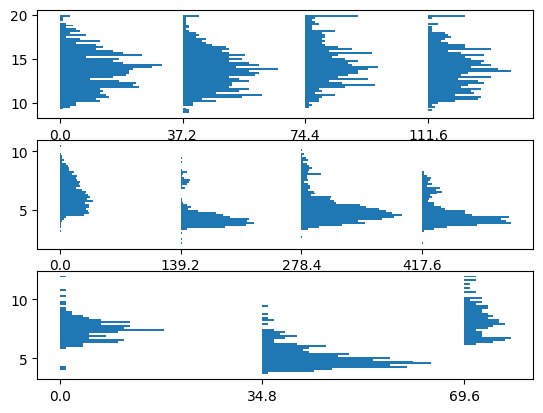

In [13]:
# Plot Data
# 3 stacked figures horizontal histograms
# each figure has a histogram for each drug treatment

nrows = 3
ncols = 1

# get figure type
figure_type = {}
for x in range(nrows):
    figure_type[(x, 0)] = "horhist"

# get figure data
figure_data = {}
for x, batch in enumerate(Batches):
    figure_data[(x, 0)] = {}

    figure_data[(x, 0)]["horhist_data"] = amp[batch]
    figure_data[(x, 0)]["bins"] = bins[batch]

# Plot Data
fig, ax, plot_ax = plot.plot.get_figure(
    nrows=nrows, ncols=ncols, figure_type=figure_type, figure_data=figure_data
)

No data for: 
 []


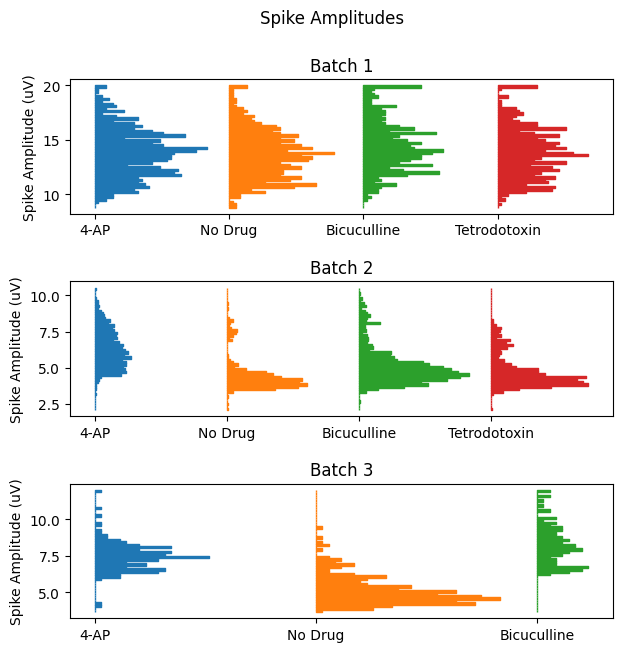

In [14]:
# Customize Plot

# Customize
batch_titles = list(labels.keys())
plot_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

# Figure Customization
fig.suptitle(f"Spike Amplitudes")
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.set_figheight(7)
fig.set_figwidth(7)

# Axis Customization
for idx, a in enumerate(ax):
    a.set_title(f"{batch_titles[idx]}")
    a.set_ylabel("Spike Amplitude (uV)")
    a.set_xticklabels(labels[batch_titles[idx]])

# Plot axis customization
for pax in plot_ax.values():  # plot ax

    # 2D list (4 , 50 value list)
    for gidx, gax in enumerate(pax):  # group axis
        for bax in gax:  # bar axis
            bax.set_color(plot_colors[gidx])

print(f"No data for: \n {no_data}")
fig

In [15]:
# FIRING MAP

In [17]:
# Create Experiment Ditionaries
# experiment info , session times , used electrodes , artifacts , sharps
# Contains 5 min segments used as example (don't have to use these segments)
Batches = ["Batch 1", "Batch 2", "Batch 3"]
Drugs = ["4-AP", "No Drug", "Bicuculline", "Tetrodotoxin"]
Organoids = {}
Organoids["Batch 1"] = ["O09", "O10", "O11", "O12"]
Organoids["Batch 2"] = ["O13", "O14", "O15", "O16"]
Organoids["Batch 3"] = ["O17", "O18", "O19", "O20"]


used_electrodes = {
    "O09": 32,
    "O10": 16,
    "O11": 20,
    "O12": 14,
    "O13": 25,
    "O14": 13,
    "O15": 11,
    "O16": 11,
    "O17": 22,
    "O18": 19,
    "O19": 20,
    "O20": 17,
}

session_times = {}  # middle of each 5 minute interval
session_times["Batch 1"] = {}
session_times["Batch 2"] = {}
session_times["Batch 3"] = {}

# Batch 1
session_times["Batch 1"]["O09_4-AP"] = datetime.datetime(2023, 5, 18, 12, 54)
session_times["Batch 1"]["O10_4-AP"] = datetime.datetime(2023, 5, 18, 12, 56)
session_times["Batch 1"]["O11_4-AP"] = datetime.datetime(2023, 5, 18, 12, 56)
session_times["Batch 1"]["O12_4-AP"] = datetime.datetime(2023, 5, 18, 12, 54)

session_times["Batch 1"]["O09_No Drug"] = datetime.datetime(2023, 5, 18, 18, 46)
session_times["Batch 1"]["O10_No Drug"] = datetime.datetime(2023, 5, 18, 18, 42)
session_times["Batch 1"]["O11_No Drug"] = datetime.datetime(2023, 5, 18, 18, 46)
session_times["Batch 1"]["O12_No Drug"] = datetime.datetime(2023, 5, 18, 18, 44)

session_times["Batch 1"]["O09_Bicuculline"] = datetime.datetime(2023, 5, 19, 10, 2)
session_times["Batch 1"]["O10_Bicuculline"] = datetime.datetime(2023, 5, 19, 10, 1)
session_times["Batch 1"]["O11_Bicuculline"] = datetime.datetime(2023, 5, 19, 10, 4)
session_times["Batch 1"]["O12_Bicuculline"] = datetime.datetime(2023, 5, 19, 9, 59)

session_times["Batch 1"]["O09_Tetrodotoxin"] = datetime.datetime(2023, 5, 19, 16, 16)
session_times["Batch 1"]["O10_Tetrodotoxin"] = datetime.datetime(2023, 5, 19, 16, 12)
session_times["Batch 1"]["O11_Tetrodotoxin"] = datetime.datetime(2023, 5, 19, 16, 17)
session_times["Batch 1"]["O12_Tetrodotoxin"] = datetime.datetime(2023, 5, 19, 16, 15)

# Batch 2
session_times["Batch 2"]["O13_4-AP"] = datetime.datetime(2023, 6, 8, 19, 33)
session_times["Batch 2"]["O14_4-AP"] = datetime.datetime(2023, 6, 8, 19, 24)
session_times["Batch 2"]["O15_4-AP"] = datetime.datetime(2023, 6, 8, 19, 26)
session_times["Batch 2"]["O16_4-AP"] = datetime.datetime(2023, 6, 8, 19, 27)

session_times["Batch 2"]["O13_No Drug"] = datetime.datetime(2023, 6, 9, 0, 1)
session_times["Batch 2"]["O14_No Drug"] = datetime.datetime(2023, 6, 8, 23, 56)
session_times["Batch 2"]["O15_No Drug"] = datetime.datetime(2023, 6, 9, 0, 1)
session_times["Batch 2"]["O16_No Drug"] = datetime.datetime(2023, 6, 9, 0, 4)

session_times["Batch 2"]["O13_Bicuculline"] = datetime.datetime(2023, 6, 9, 10, 45)
session_times["Batch 2"]["O14_Bicuculline"] = datetime.datetime(2023, 6, 9, 10, 45)
session_times["Batch 2"]["O15_Bicuculline"] = datetime.datetime(2023, 6, 9, 10, 46)
session_times["Batch 2"]["O16_Bicuculline"] = datetime.datetime(2023, 6, 9, 10, 50)

session_times["Batch 2"]["O13_Tetrodotoxin"] = datetime.datetime(2023, 6, 9, 16, 4)
session_times["Batch 2"]["O14_Tetrodotoxin"] = datetime.datetime(2023, 6, 9, 16, 4)
session_times["Batch 2"]["O15_Tetrodotoxin"] = datetime.datetime(2023, 6, 9, 16, 13)
session_times["Batch 2"]["O16_Tetrodotoxin"] = datetime.datetime(2023, 6, 9, 16, 7)

# Batch 3
session_times["Batch 3"]["O17_4-AP"] = datetime.datetime(2023, 7, 12, 13, 32)
session_times["Batch 3"]["O18_4-AP"] = datetime.datetime(2023, 7, 12, 13, 31)
session_times["Batch 3"]["O19_4-AP"] = datetime.datetime(2023, 7, 12, 13, 34)
session_times["Batch 3"]["O20_4-AP"] = datetime.datetime(2023, 7, 12, 13, 34)

session_times["Batch 3"]["O17_No Drug"] = datetime.datetime(2023, 7, 12, 16, 32)
session_times["Batch 3"]["O18_No Drug"] = datetime.datetime(2023, 7, 12, 16, 37)
session_times["Batch 3"]["O19_No Drug"] = datetime.datetime(2023, 7, 12, 16, 34)
session_times["Batch 3"]["O20_No Drug"] = datetime.datetime(2023, 7, 12, 16, 43)

session_times["Batch 3"]["O17_Bicuculline"] = datetime.datetime(2023, 7, 13, 12, 58)
session_times["Batch 3"]["O18_Bicuculline"] = datetime.datetime(2023, 7, 13, 13, 8)
session_times["Batch 3"]["O19_Bicuculline"] = datetime.datetime(2023, 7, 13, 13, 2)
session_times["Batch 3"]["O20_Bicuculline"] = datetime.datetime(2023, 7, 13, 13, 7)

session_times["Batch 3"]["O17_Tetrodotoxin"] = datetime.datetime(2023, 7, 13, 18, 36)
session_times["Batch 3"]["O18_Tetrodotoxin"] = datetime.datetime(2023, 7, 13, 18, 39)
session_times["Batch 3"]["O19_Tetrodotoxin"] = datetime.datetime(2023, 7, 13, 18, 41)
session_times["Batch 3"]["O20_Tetrodotoxin"] = datetime.datetime(2023, 7, 13, 18, 40)

In [18]:
# Get Tasks (ephys.ClusteringTask())
# One 5 min segment for each drug and organoid (from dictionaries above)

paramset_idx = 1

global_key = []
for batch in Batches:
    for drug in Drugs:
        for organoid in Organoids[batch]:

            # Find sesssion
            title = f"{organoid}_{drug}"
            time = session_times[batch][title]

            start_time = (time - datetime.timedelta(minutes=2)).strftime(
                "%Y-%m-%d %H:%M:%S"
            )
            end_time = (time + datetime.timedelta(minutes=3)).strftime(
                "%Y-%m-%d %H:%M:%S"
            )

            key = {
                "organoid_id": organoid,
                "start_time": start_time,
                "end_time": end_time,
                "paramset_idx": paramset_idx,
            }
            global_key.append(key)

Tasks = plot.data.get_tasks(global_key=global_key)

Tasks

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,clustering_output_dir clustering output directory relative to the clustering root data directory
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,O09-12_raw/202305181252_202305181257/O09/spykingcircus2_1
O09,2023-05-18 18:15:00,0,2023-05-18 18:44:00,2023-05-18 18:49:00,1,O09-12_raw/202305181844_202305181849/O09/spykingcircus2_1
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,1,O09-12_raw/202305191000_202305191005/O09/spykingcircus2_1
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,O09-12_raw/202305181254_202305181259/O10/spykingcircus2_1
O10,2023-05-18 18:15:00,0,2023-05-18 18:40:00,2023-05-18 18:45:00,1,O09-12_raw/202305181840_202305181845/O10/spykingcircus2_1
O10,2023-05-19 09:30:00,0,2023-05-19 09:59:00,2023-05-19 10:04:00,1,O09-12_raw/202305190959_202305191004/O10/spykingcircus2_1
O10,2023-05-19 15:45:00,0,2023-05-19 16:10:00,2023-05-19 16:15:00,1,O09-12_raw/202305191610_202305191615/O10/spykingcircus2_1
O11,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,O09-12_raw/202305181254_202305181259/O11/spykingcircus2_1
O11,2023-05-18 18:15:00,0,2023-05-18 18:44:00,2023-05-18 18:49:00,1,O09-12_raw/202305181844_202305181849/O11/spykingcircus2_1
O11,2023-05-19 09:30:00,0,2023-05-19 10:02:00,2023-05-19 10:07:00,1,O09-12_raw/202305191002_202305191007/O11/spykingcircus2_1


In [19]:
# Firing Map Plots (Spike times and electrodes)

global_query = ephys.CuratedClustering.Unit()
Values = ["electrode", "spike_times"]

data = plot.data.get_data(Tasks=Tasks, global_query=global_query, Values=Values)

In [20]:
# Convert Data

new_data = {}
time_vec = list(range(0, 301))

for key, value in data.items():

    if value == "no data":
        new_data[key] = "no data"

    else:

        # Extract Values
        electrodes = value["electrode"]
        spike_times = value["spike_times"]

        # Extract Organoid Number
        organoid = key.split("/")[2]

        # Loop through valid electrodes (inside organoid)
        # Group Together the same electrodes and convert to histogram

        used_elec = El2ROW[list(range(used_electrodes[organoid]))]
        spike_array = np.empty((0, 300), dtype=int)
        elec_list = []

        for elec in used_elec:
            if elec in electrodes:

                # Find spikes for single electrode
                elec_spikes = np.concatenate(spike_times[electrodes == elec])

                # Convert into histogram format
                elec_spike_hist, _ = np.histogram(elec_spikes, bins=time_vec)

                # Average firing rate basedd on number of units per electrode
                # elec_spike_hist /= len(spike_times[electrodes == elec])

                # Append to Global
                spike_array = np.append(spike_array, [list(elec_spike_hist)], axis=0)
                elec_list.append(elec)
            else:
                spike_array = np.append(spike_array, [list(np.zeros(300))], axis=0)

        # Limit data to 95th percentile
        p95 = int(np.percentile(spike_array, 95))
        spike_array[spike_array > p95] = p95

        new_data[key] = spike_array

In [21]:
# Group Data

spike_data = plot.data.group_data(
    data=new_data,
    batch=True,
    drug=True,
    organoid=True,
    dict_order=["batch/organoid", "drug"],
)

# Reorder (based on drug chronicalogically)
order = ["4-AP", "No Drug", "Bicuculline", "Tetrodotoxin"]
for key1, drug_dict in spike_data.items():
    new_dict = {}

    for key2 in order:

        try:
            new_dict[key2] = drug_dict[key2]
        except:
            continue

    spike_data[key1] = new_dict

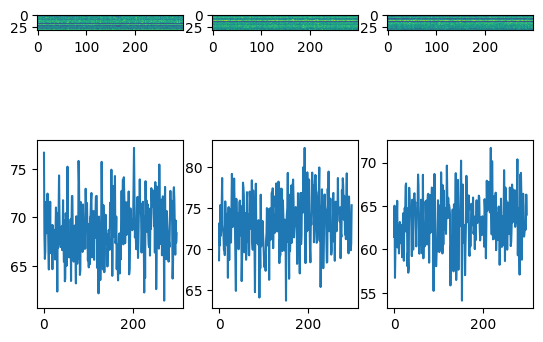

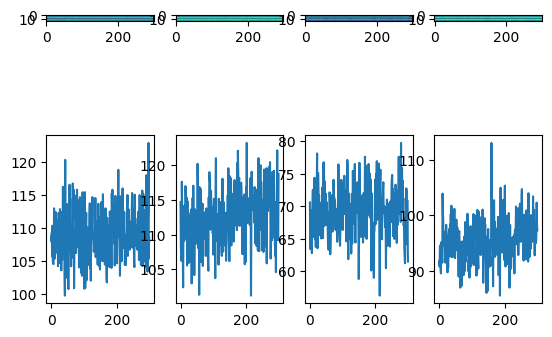

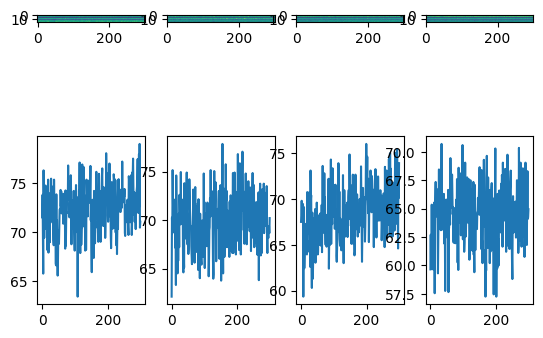

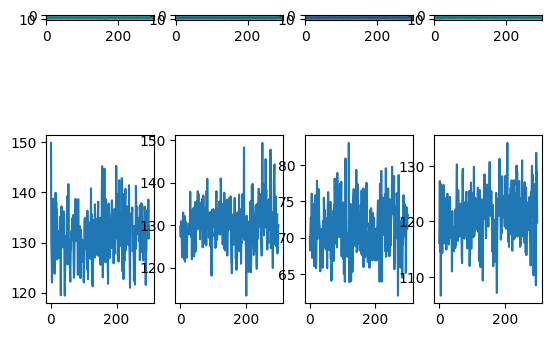

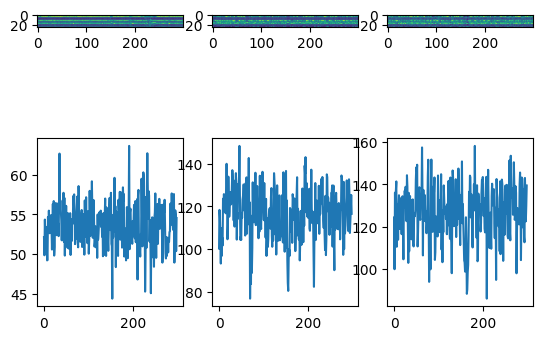

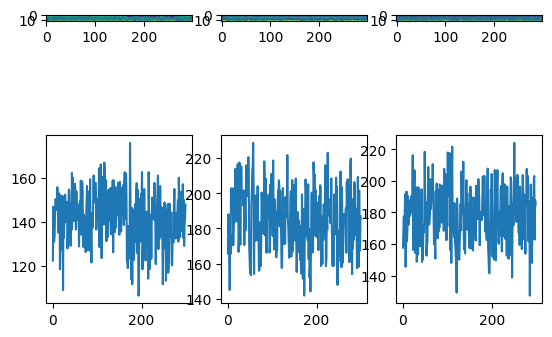

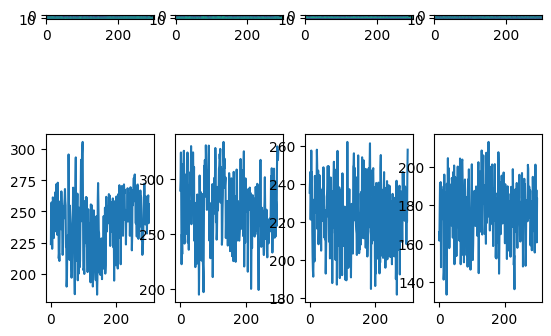

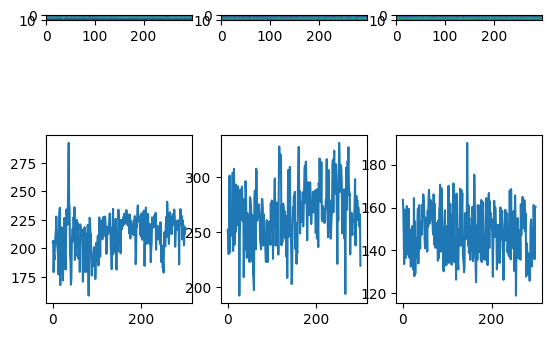

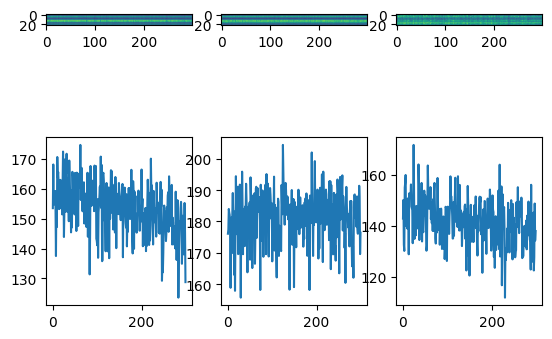

In [22]:
# Plot Data

# Plot Loop
labels = {}
fig = []
axes = []
plot_axes = []
cbar_max = []
line_max = []
plot_idx = {"4-AP": 0, "No Drug": 1, "Bicuculline": 2, "Tetrodotoxin": 3}

for idx, (organoid, drug_dict) in enumerate(
    spike_data.items()
):  # each iteration generates a new figure (through organoids)
    figure_type = {}
    figure_data = {}

    nrows = 2
    ncols = len(drug_dict)

    for y in range(ncols):
        figure_type[(0, y)] = "image"
        figure_type[(1, y)] = "line"

    cbar_max.append(np.percentile(np.array(list(drug_dict.values())), 95))

    label_list = []
    line_list = []
    for i, (drug, plot_data) in enumerate(drug_dict.items()):

        plot_data = plot_data[0]  # Account for group_data making a list

        if isinstance(plot_data[0], str):
            figure_type[(0, i)] = "no data"
            figure_type[(1, i)] = "no data"

        else:

            figure_data[(0, i)] = {}
            figure_data[(1, i)] = {}

            figure_data[(0, i)]["image_data"] = plot_data
            line = np.mean(plot_data, axis=0)
            figure_data[(1, i)]["line_data"] = line
            line_list.append(np.max(line))

            label_list.append(drug)

    labels[organoid] = label_list
    line_max.append(line_list)

    f, ax, pax = plot.plot.get_figure(
        nrows=nrows, ncols=ncols, figure_type=figure_type, figure_data=figure_data
    )
    fig.append(f)
    axes.append(ax)
    plot_axes.append(pax)

In [27]:
# Customize Plot


for i in list(range(len(spike_data))):

    title = list(labels.keys())[i]

    # Figure Customization
    fig[i].suptitle(title)
    fig[i].set_figheight(4)
    fig[i].set_figwidth(8)

    image_axes = axes[i][0][:]
    for i_idx, iax in enumerate(image_axes):
        iax.set_aspect("auto")
        iax.set_title(labels[title][i_idx])
        iax.set_xticks([])
        iax.set_yticks([])

    pax = plot_axes[i]
    norm = mcolors.Normalize(vmin=0, vmax=cbar_max[i])

    for plotkey, plotvalue in pax.items():
        if isinstance(plotvalue, image.AxesImage):
            plotvalue.set_cmap("bwr")
            plotvalue.set_norm(norm=norm)

            pval = plotvalue

    cbar = fig[i].colorbar(pval, ax=iax, ticks=[0, cbar_max[i]])
    cbar.set_label("Hz", loc="center", rotation=0)

    line_axes = axes[i][1][:]
    for l_idx, lax in enumerate(line_axes):
        lax.set_xticks([300])
        lax.set_xticklabels([f"~ 300s"])
        lax.set_yticks([line_max[i][l_idx]])
        lax.tick_params(axis="y", labelrotation=90)

    image_axes[0].set_ylabel("Channels")
    line_axes[0].set_ylabel("Spikes/s")

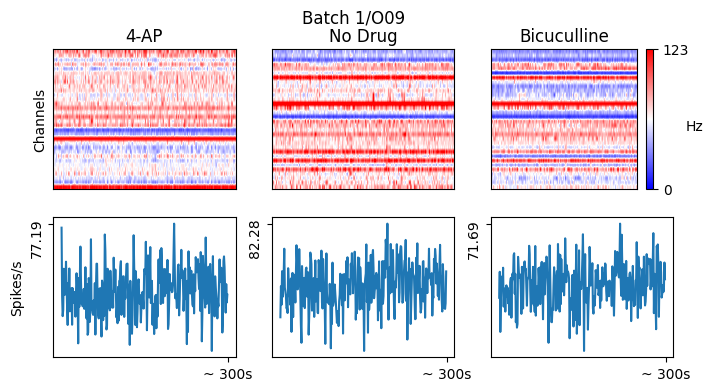

In [28]:
fig[0]

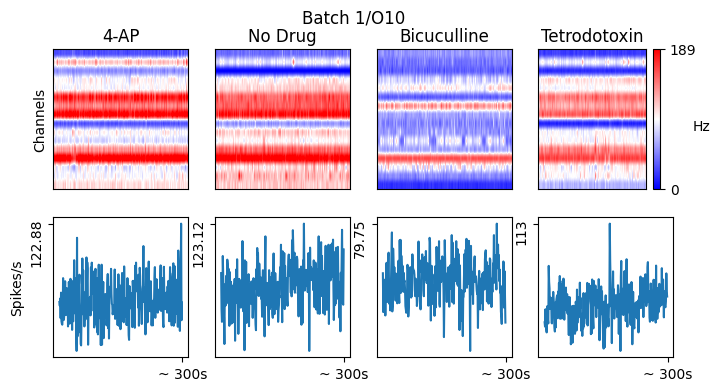

In [29]:
fig[1]

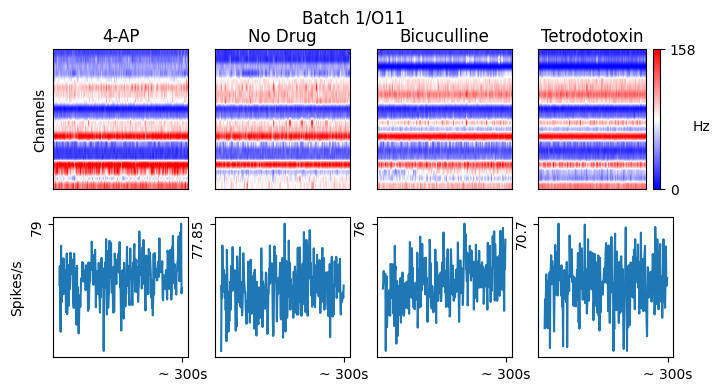

In [30]:
fig[2]

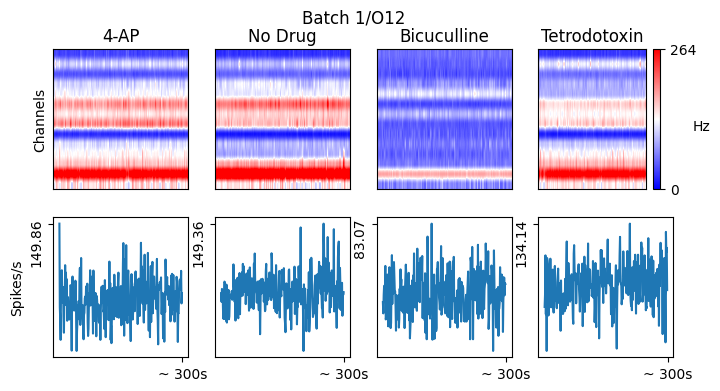

In [31]:
fig[3]

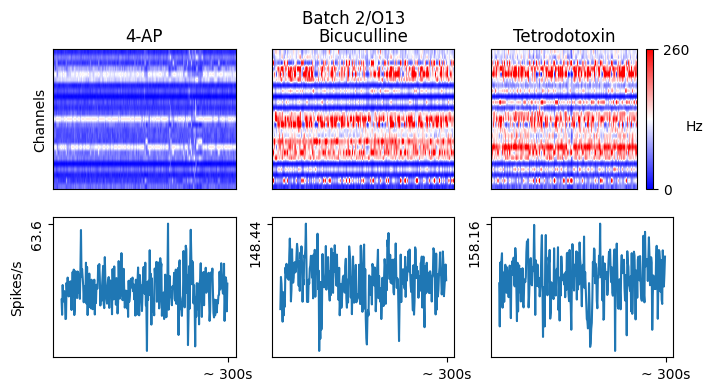

In [32]:
fig[4]

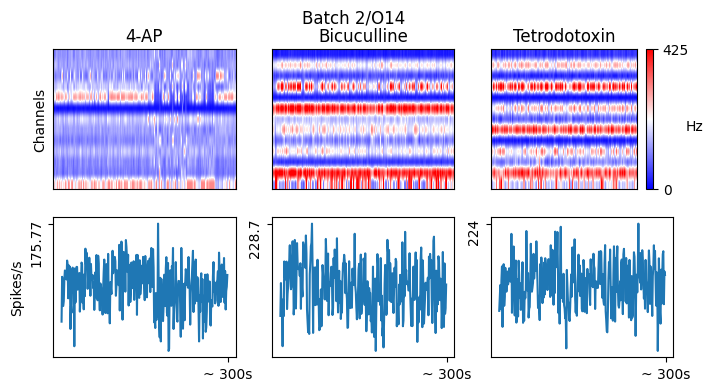

In [33]:
fig[5]

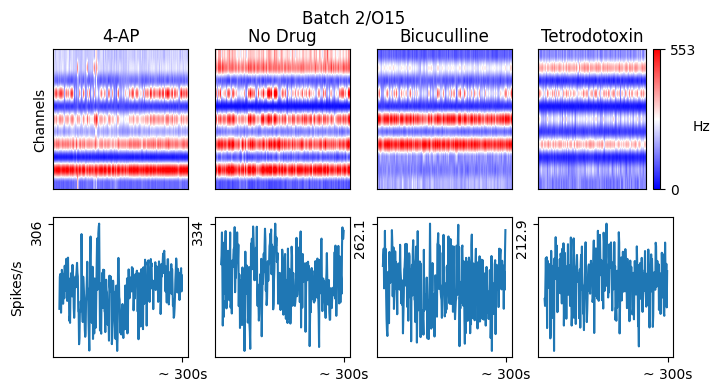

In [34]:
fig[6]

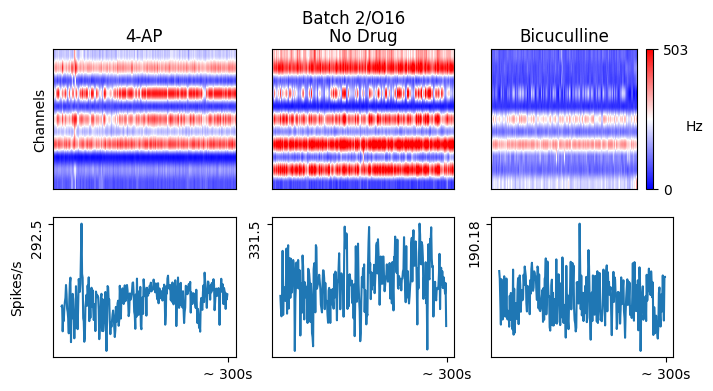

In [35]:
fig[7]

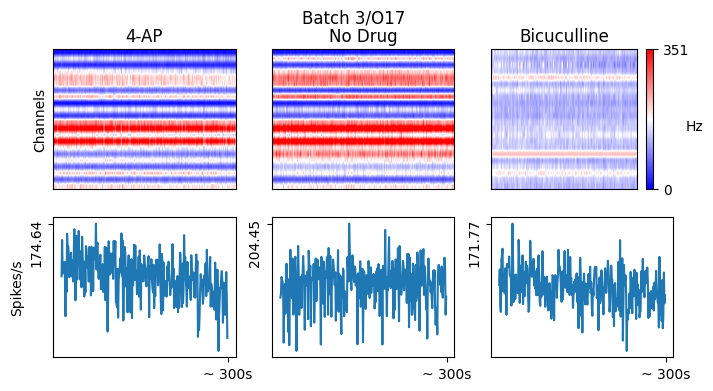

In [36]:
fig[8]